# Convolutional Neural Network - Pattern Recognition in Stock Markets

In [1]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
#import pandas_datareader as pdr
import csv
import warnings
from keras import layers
from keras import models


N = 40

Using TensorFlow backend.


In [2]:
%matplotlib inline

In [3]:
#hide all warnings
#warnings.filterwarnings('ignore')

#show all warnings just once
warnings.filterwarnings(action='once')

In [4]:
from helpers import delete_nans, get_returns, plot_example_returns, tickers, get_data_subsets#, data_loader

/Users/SirLukeSchande/.pyenv/versions/3.6.10/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/SirLukeSchande/.pyenv/versions/3.6.10/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/SirLukeSchande/.pyenv/versions/3.6.10/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/SirLukeSchande/.pyenv/versions/3.6.10/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/SirLukeSchande/.pyenv

# Download Data

In [5]:
begin = "2007-01-01"
finish = "2017-01-01"

#data_loader(begin, finish, 'returns.csv')

In [6]:
returns = get_returns('returns.csv', N)

Number of columns with only NaNs: 0
Number of lines with only NaNs: 0
Number of NaNs: 0
shape Dataframe: (2518, 40)


## Helper Functions

,MMM,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,...,AEE,AAL,AEP,AXP,AIG,AMT,AWK,AMP,ABC,AME
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-03,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
2007-01-04,-0.003961,0.018991,0.0,0.021352,0.022540,0.008158,0.022545,0.013832,0.006464,0.000456,...,-0.002963,0.045115,-0.000233,-0.007290,-0.008871,-0.003947,0.0,0.006519,0.003904,-0.006293
2007-01-05,-0.006799,0.000000,0.0,-0.014634,-0.013979,-0.005780,-0.004900,-0.004043,-0.022061,-0.028702,...,-0.013559,-0.009347,-0.018674,-0.013184,-0.004615,-0.008719,0.0,-0.001439,-0.012098,-0.018683
2007-01-08,0.002195,0.003607,0.0,-0.002122,0.014449,-0.000581,-0.004185,-0.012177,0.003427,-0.014071,...,0.000941,-0.006176,-0.000714,0.009470,0.004917,0.028518,0.0,0.012432,0.015745,0.001613
2007-01-09,0.001160,0.008786,0.0,-0.010631,-0.002419,-0.000582,-0.020272,0.009245,0.008537,-0.040914,...,0.003386,-0.000518,0.009522,-0.006366,-0.003355,0.014512,0.0,0.006051,-0.003229,0.000000


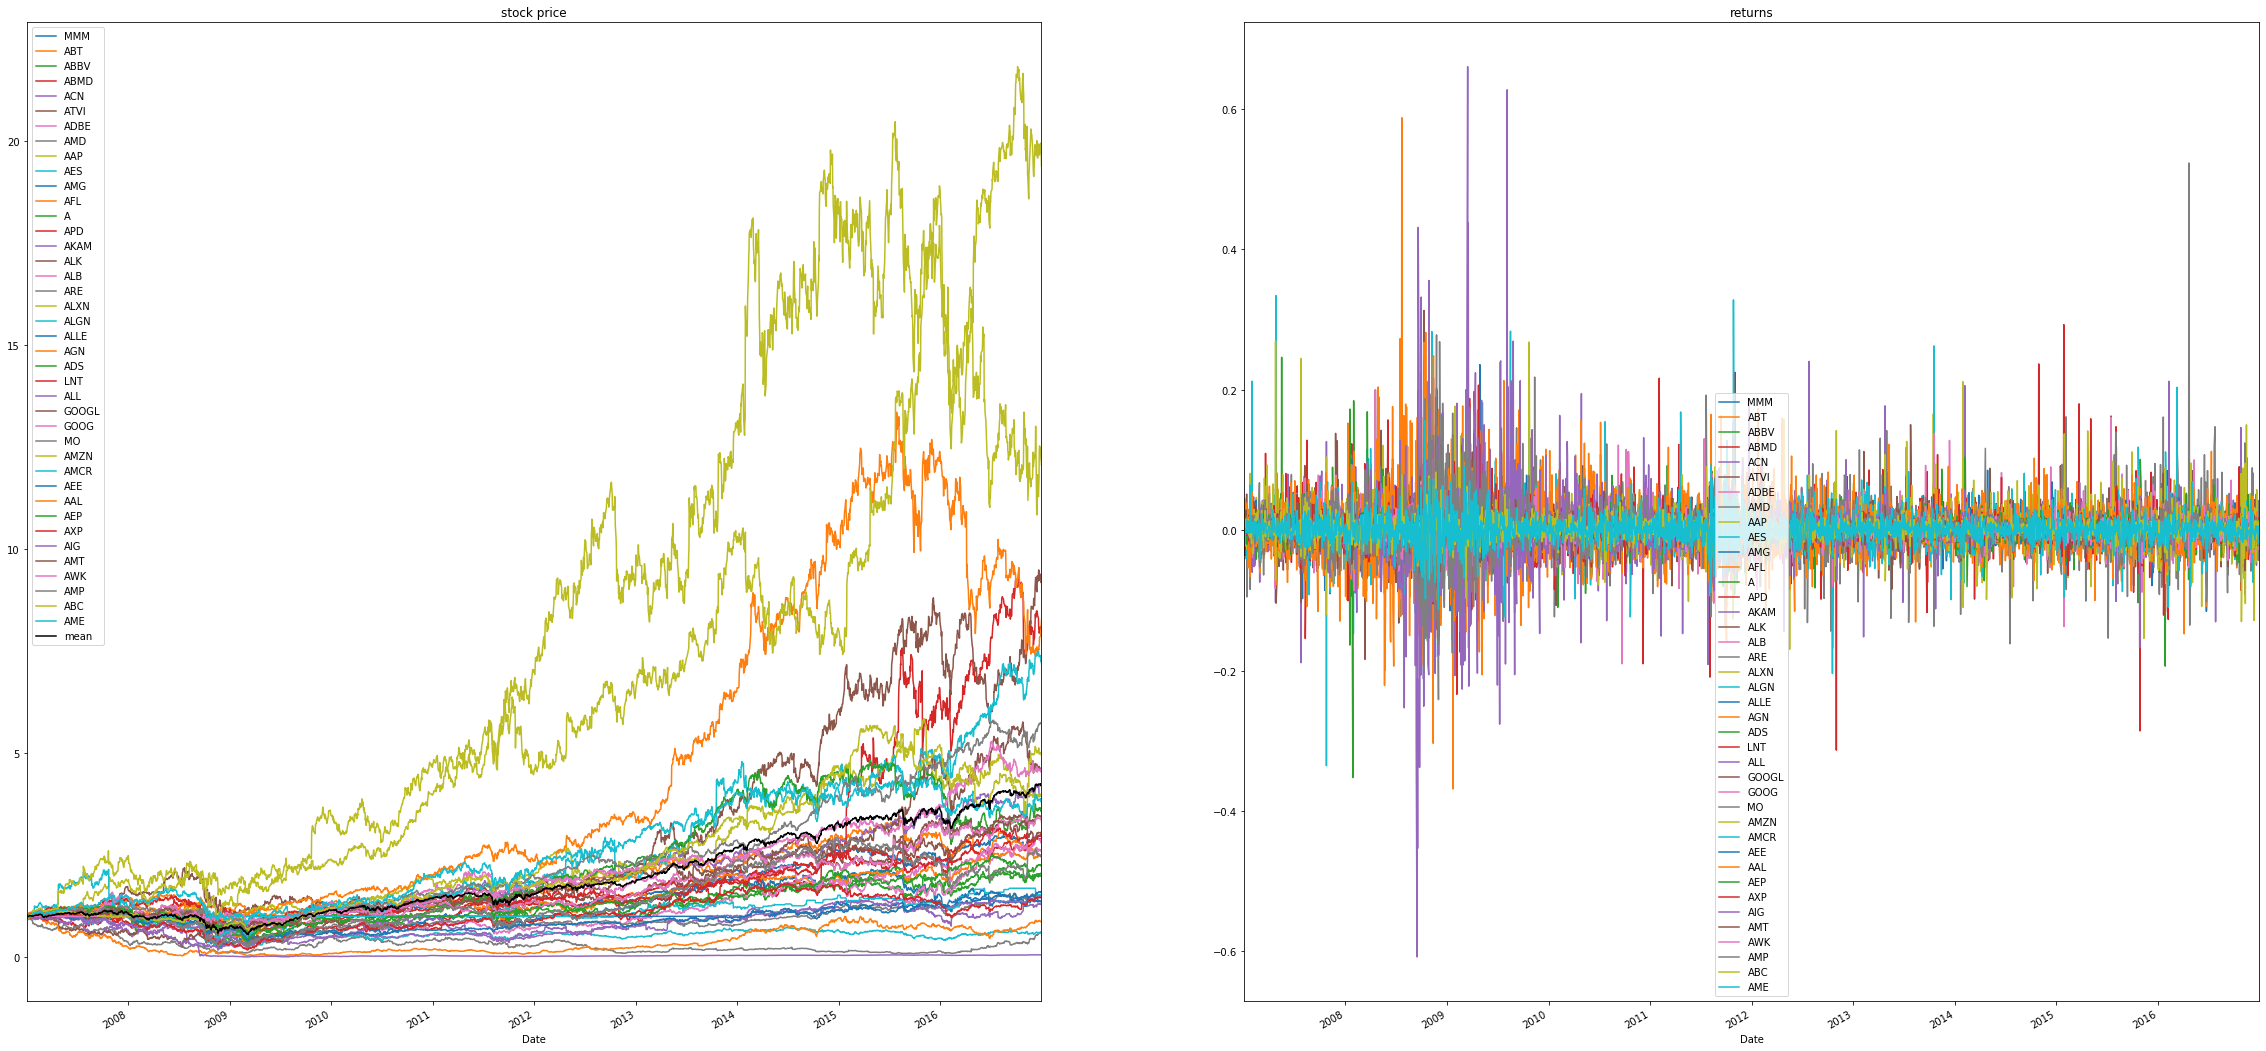

In [7]:
delete_nans('returns.csv', 'returns.csv')
plot_example_returns('returns.csv', N)

## Calculations 

In [16]:
def cnn(x_train, y_train, x_test, y_test, inp_shape):
    verbose, epochs, batch_size = 1,10, 50 
    """
    verbose: 0-kein output, 1-ladebalken, 2-epochenzahlen printen
    batch_size: Nicht definieren (https://stackoverflow.com/questions/44747343/keras-input-explanation-input-shape-units-batch-size-dim-etc)
    epochs: Anzahl Iterationen durch das Trainingsset
    """
    
    N = inp_shape[1]
    #init
    model = models.Sequential()
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu',
                     input_shape=inp_shape))
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
    #Conv1D => 1D Convolution (Schaut nach Mustern)
    #mit filters = Anzahl Weight Functions, kernel_size = Anzahl simultan betrachteter Felder, 
    #relu = 0 für value<0 sonst linear
    
    model.add(layers.Dropout(0.5))
    #Dropout sets randomly chosen values to 0 to prevent overfitting
    
    model.add(layers.MaxPooling1D(pool_size=2))
    #MaxPooling halbiert array Größe und nimmt größte Werte der Feature-Gewichtungen 
    
    model.add(layers.Flatten())
    #Flatten reduziert dimensionen eines arrays auf niedrigst mögliche Dimension (1xdim) (überschreibt Nullen))
    
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(N, activation='linear'))
    #Klassisches NN hinter Convolutional Layer geschaltet, lernt also im Feature Raum, durch Convolutional Net vorgebenen
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae']) 
    #mean_squared_error (mse) and mean_absolute_error (mae)
    
    #fit network
    model.fit(x_train,y_train, epochs=epochs, #batch_size=batch_size, 
              verbose=verbose)
    #evaluate model
    
    #Print error values for classification of goodness
    mse,mse2,mae = model.evaluate(x_test,y_test, batch_size=batch_size, verbose=verbose)
    print(mse)
    print(mse2)
    print(mae)
    return model
    

In [85]:
def fully(x_train,y_train,x_test,y_test,inp_shape):
    verbose, epochs, batch_size = 1, 10, 50 
    """
    verbose: 0-kein output, 1-ladebalken, 2-epochenzahlen printen
    batch_size: Nicht definieren (https://stackoverflow.com/questions/44747343/keras-input-explanation-input-shape-units-batch-size-dim-etc)
    epochs: Anzahl Iterationen durch das Trainingsset
    """
    
    N = inp_shape[1]
    #init
    model = models.Sequential()
    model.add(layers.Dense(100, activation='tanh'))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dropout(.1))
    model.add(layers.Dense(100, activation='tanh'))
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(N, activation='linear'))
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae']) 
    #mean_squared_error (mse) and mean_absolute_error (mae)
    
    #fit network
    model.fit(x_train,y_train, epochs=epochs, #batch_size=batch_size, 
              verbose=verbose)
    #evaluate model
    
    #Print error values for classification of goodness
    mse,mse2,mae = model.evaluate(x_test,y_test, batch_size=batch_size, verbose=verbose)
    print(mse)
    print(mse2)
    print(mae)
    return model
    

In [86]:
def rnn(x_train, y_train, x_test, y_test, inp_shape):
    verbose, epochs, batch_size = 1, 100, 50 
    """
    verbose: 0-kein output, 1-ladebalken, 2-epochenzahlen printen
    batch_size: Nicht definieren (https://stackoverflow.com/questions/44747343/keras-input-explanation-input-shape-units-batch-size-dim-etc)
    epochs: Anzahl Iterationen durch das Trainingsset
    """
    
    N = inp_shape[1]
    #init
    model = models.Sequential()
    model.add(layers.GRU(42, input_shape = inp_shape, return_sequences = True))
    model.add(layers.Dropout(0.2))
    model.add(layers.GRU(42, return_sequences = False))
    
    #Dropout sets randomly chosen values to 0 to prevent overfitting
    
    #model.add(layers.MaxPooling1D(pool_size=2))
    #MaxPooling halbiert array Größe und nimmt größte Werte der Feature-Gewichtungen 
    
    #model.add(layers.Flatten())
    #Flatten reduziert dimensionen eines arrays auf niedrigst mögliche Dimension (1xdim) (überschreibt Nullen))
    
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(N, activation='linear'))
    #Klassisches NN hinter Convolutional Layer geschaltet, lernt also im Feature Raum, durch Convolutional Net vorgebenen
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae']) 
    #mean_squared_error (mse) and mean_absolute_error (mae)
    
    #fit network
    model.fit(x_train,y_train, epochs=epochs, #batch_size=batch_size, 
              verbose=verbose)
    #evaluate model
    
    #Print error values for classification of goodness
    mse,mse2,mae = model.evaluate(x_test,y_test, batch_size=batch_size, verbose=verbose)
    print(mse)
    print(mse2)
    print(mae)
    return model
    

Die Funktion get_data_subsets unterteilt die Matrix in eine Matrix der Dimension dur x N (Zeitfenster x Stocks) und korrespondierender Vektor für den Tag darauf (dur=1 x stocks). Jedes Matrix-Vektor Paar stellt einen Input plus Target Output(Label, Lösung) dar.

In [22]:
def main(input_df, dur, limit):
    """
    input_df    die Input Matrix (duh)
    dur         Zeitfenster
    limit       Grenze für Train Test Split
    """

    N = input_df.shape[1]
    D = input_df.shape[0]
    train = input_df.iloc[:limit,:]
    test = input_df.iloc[limit-dur:,:]
    x_train,y_train = get_data_subsets(train, dur) 
    x_test,y_test = get_data_subsets(test, dur)
    inp_shape = (dur,N)
    
    x_train = x_train[:,x_train.shape[1]-dur:,:]
    x_test = x_test[:,x_test.shape[1]-dur:,:]
    
    """für Dimensions-tests"""
    print('x-train shape: ' + str(x_train.shape))
    print('y-train shape: ' + str(y_train.shape))
    print('x-test shape: ' + str(x_test.shape))
    print('y-test shape: ' + str(y_test.shape))
    print('test shape: ' + str(test.shape))
    
    model = cnn(x_train, y_train, x_test, y_test, inp_shape)
    return model,x_train,y_train,x_test,y_test

In [87]:
def main_fully_connected(input_df, dur, limit):
    """
    input_df    die Input Matrix (duh)
    dur         Zeitfenster
    limit       Grenze für Train Test Split
    """

    N = input_df.shape[1]
    D = input_df.shape[0]
    train = input_df.iloc[:limit,:]
    test = input_df.iloc[limit-dur:,:]
    x_train,y_train = get_data_subsets(train, dur) 
    x_test,y_test = get_data_subsets(test, dur)
    inp_shape = (x_train.shape[1],N)
    
    """für Dimensions-tests"""
    print('x-train shape: ' + str(x_train.shape))
    print('y-train shape: ' + str(y_train.shape))
    print('x-test shape: ' + str(x_test.shape))
    print('y-test shape: ' + str(y_test.shape))
    print('test shape: ' + str(test.shape))
    
    model = fully(x_train, y_train, x_test, y_test, inp_shape)
    return model,x_train,y_train,x_test,y_test

In [13]:
def main_rnn(input_df, dur, limit):
    """
    input_df    die Input Matrix (duh)
    dur         Zeitfenster
    limit       Grenze für Train Test Split
    """

    N = input_df.shape[1]
    D = input_df.shape[0]
    train = input_df.iloc[:limit,:]
    test = input_df.iloc[limit-dur:,:]
    x_train,y_train = get_data_subsets(train, dur) 
    x_test,y_test = get_data_subsets(test, dur)
    inp_shape = (dur,N)
    
    x_train = x_train[:,x_train.shape[1]-dur:,:]
    x_test = x_test[:,x_test.shape[1]-dur:,:]
    
    """für Dimensions-tests"""
    print('x-train shape: ' + str(x_train.shape))
    print('y-train shape: ' + str(y_train.shape))
    print('x-test shape: ' + str(x_test.shape))
    print('y-test shape: ' + str(y_test.shape))
    print('test shape: ' + str(test.shape))
    
    model = rnn(x_train, y_train, x_test, y_test, inp_shape)
    return model,x_train,y_train,x_test,y_test

In [14]:
model_rnn,x_train,y_train,x_test,y_test = main_rnn(returns, 100, 2000)

1900
518
x-train shape: (1900, 109, 40)
y-train shape: (1900, 40)
x-test shape: (518, 109, 40)
y-test shape: (518, 40)
test shape: (618, 40)
Epoch 1/100
1900/1900 [==============================] - 14s 8ms/step - loss: 6.0749e-04 - mse: 6.0749e-04 - mae: 0.0149
Epoch 2/100
1900/1900 [==============================] - 12s 7ms/step - loss: 6.0251e-04 - mse: 6.0251e-04 - mae: 0.0148
Epoch 3/100
1900/1900 [==============================] - 13s 7ms/step - loss: 6.0065e-04 - mse: 6.0065e-04 - mae: 0.0148
Epoch 4/100
1900/1900 [==============================] - 13s 7ms/step - loss: 6.0062e-04 - mse: 6.0062e-04 - mae: 0.0148
Epoch 5/100
1900/1900 [==============================] - 16s 8ms/step - loss: 5.9782e-04 - mse: 5.9782e-04 - mae: 0.0148
Epoch 6/100
1900/1900 [==============================] - 14s 7ms/step - loss: 5.9815e-04 - mse: 5.9815e-04 - mae: 0.0148
Epoch 7/100
1900/1900 [==============================] - 14s 7ms/step - loss: 5.9531e-04 - mse: 5.9531e-04 - mae: 0.0148
Epoch 8/100


KeyboardInterrupt: 

In [23]:
model_cnn,x_train,y_train,x_test,y_test = main(returns, 100, 2000)

1900
518
x-train shape: (1900, 100, 40)
y-train shape: (1900, 40)
x-test shape: (518, 100, 40)
y-test shape: (518, 40)
test shape: (618, 40)
Epoch 1/10
1900/1900 [==============================] - 2s 991us/step - loss: 5.8903e-04 - mse: 5.8903e-04 - mae: 0.0148
Epoch 2/10
1900/1900 [==============================] - 2s 823us/step - loss: 5.6579e-04 - mse: 5.6579e-04 - mae: 0.0143
Epoch 3/10
1900/1900 [==============================] - 2s 863us/step - loss: 5.6436e-04 - mse: 5.6436e-04 - mae: 0.0143
Epoch 4/10
1120/1900 [================>.............] - ETA: 0s - loss: 5.2631e-04 - mse: 5.2631e-04 - mae: 0.0140

KeyboardInterrupt: 

In [88]:
model_fully,x_train,y_train,x_test,y_test = main_fully_connected(returns, 100, 2000)

1900
518
x-train shape: (1900, 109, 40)
y-train shape: (1900, 40)
x-test shape: (518, 109, 40)
y-test shape: (518, 40)
test shape: (618, 40)
Epoch 1/10
1900/1900 [==============================] - 3s 2ms/step - loss: 7.7355e-04 - mse: 7.7355e-04 - mae: 0.0167
Epoch 2/10
1900/1900 [==============================] - 3s 2ms/step - loss: 6.0127e-04 - mse: 6.0127e-04 - mae: 0.0147
Epoch 3/10
1900/1900 [==============================] - 3s 1ms/step - loss: 6.0146e-04 - mse: 6.0146e-04 - mae: 0.0147
Epoch 4/10
1900/1900 [==============================] - 3s 2ms/step - loss: 6.0119e-04 - mse: 6.0119e-04 - mae: 0.0147
Epoch 5/10
1900/1900 [==============================] - 3s 2ms/step - loss: 6.0178e-04 - mse: 6.0178e-04 - mae: 0.0147
Epoch 6/10
1900/1900 [==============================] - 3s 1ms/step - loss: 6.0127e-04 - mse: 6.0127e-04 - mae: 0.0147
Epoch 7/10
1900/1900 [==============================] - 3s 1ms/step - loss: 6.0235e-04 - mse: 6.0235e-04 - mae: 0.0147
Epoch 8/10
1900/1900 [====

In [ ]:
print(model_fully.summary())

In [ ]:
print(model_cnn.summary())

In [ ]:
print(model_rnn.summary())

In [8]:
def cnn_2inputs(xtrain,ytrain,xtest,ytest,inp_shape1,inp_shape2):
    verbose, epochs, batch_size = 1,10, 50 
    """
    verbose: 0-kein output, 1-ladebalken, 2-epochenzahlen printen
    batch_size: Nicht definieren (https://stackoverflow.com/questions/44747343/keras-input-explanation-input-shape-units-batch-size-dim-etc)
    epochs: Anzahl Iterationen durch das Trainingsset
    """
    
    i1 = layers.Input(inp_shape1)
    i2 = layers.Input(inp_shape2)
    
    N = inp_shape1[1]
    #init
    model1 = layers.Conv1D(filters=64, kernel_size=3, activation='relu')(i1)
    model1 = layers.Conv1D(filters=64, kernel_size=3, activation='relu')(model1)
    #Conv1D => 1D Convolution (Schaut nach Mustern)
    #mit filters = Anzahl Weight Functions, kernel_size = Anzahl simultan betrachteter Felder, 
    #relu = 0 für value<0 sonst linear
    
    model1 = layers.Dropout(0.1)(model1)
    #Dropout sets randomly chosen values to 0 to prevent overfitting
    
    model1 = layers.MaxPooling1D(pool_size=2)(model1)
    #MaxPooling halbiert array Größe und nimmt größte Werte der Feature-Gewichtungen 
    
    model1 = layers.Flatten()(model1)
    #Flatten reduziert dimensionen eines arrays auf niedrigst mögliche Dimension (1xdim) (überschreibt Nullen))
    model1 = models.Model(inputs = i1, outputs = model1)
    
    
    ### second network:
    model2 = layers.Flatten()(i2)
    model2 = layers.Dense(100, activation="relu")(model2)
    #model2 = layers.Dropout(0.01)(model2)
    #model2 = layers.Dense(100, activation="relu")(model2)
    model2 = models.Model(inputs = i2, outputs = model2)
    
    combined = layers.concatenate([model1.output, model2.output])
    
    
    model = layers.Dense(100, activation='relu')(combined)
    model = layers.Dense(N, activation='linear')(model)
    model = models.Model(inputs = [model1.input, model2.input], outputs = model)
    #Klassisches NN hinter Convolutional Layer geschaltet, lernt also im Feature Raum, durch Convolutional Net vorgebenen
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae']) 
    #mean_squared_error (mse) and mean_absolute_error (mae)
    
    #fit network
    model.fit(xtrain,ytrain, epochs=epochs, #batch_size=batch_size, 
              verbose=verbose)
    #evaluate model
    
    #Print error values for classification of goodness
    mse,mse2,mae = model.evaluate(xtest,ytest, batch_size=batch_size, verbose=verbose)
    print(mse)
    print(mse2)
    print(mae)
    return model

In [9]:
def main_2inputs(input_df, dur, limit):
    """
    input_df    die Input Matrix (duh)
    dur         Zeitfenster
    limit       Grenze für Train Test Split
    """

    N = input_df.shape[1]
    D = input_df.shape[0]
    train = input_df.iloc[:limit,:]
    test = input_df.iloc[limit-dur:,:]
    x_train,y_train = get_data_subsets(train, dur) 
    x_test,y_test = get_data_subsets(test, dur)
    inp_shape1 = (dur,N)
    inp_shape2 = (x_train.shape[1]-dur,N)
    x_train = [x_train[:,inp_shape2[0]:,:],x_train[:,:inp_shape2[0],:]]
    x_test = [x_test[:,inp_shape2[0]:,:],x_test[:,:inp_shape2[0],:]]
    
    """für Dimensions-tests"""
    print('x-train shape: ' + str(x_train[0].shape)+ str(x_train[1].shape))
    print('y-train shape: ' + str(y_train.shape))
    print('x-test shape: ' + str(x_test[0].shape)+ str(x_test[1].shape))
    print('y-test shape: ' + str(y_test.shape))
    print('test shape: ' + str(test.shape))
    
    model = cnn_2inputs(x_train, y_train, x_test, y_test, inp_shape1,inp_shape2)
    return model,x_train,y_train,x_test,y_test

In [10]:
model_cnn_2inputs,x_train,y_train,x_test,y_test = main_2inputs(returns, 100, 2000)

1900
518
x-train shape: (1900, 100, 40)(1900, 10, 40)
y-train shape: (1900, 40)
x-test shape: (518, 100, 40)(518, 10, 40)
y-test shape: (518, 40)
test shape: (618, 40)
Epoch 1/10
1900/1900 [==============================] - 2s 1ms/step - loss: 7.0046e-04 - mse: 7.0046e-04 - mae: 0.0164
Epoch 2/10
1900/1900 [==============================] - 2s 957us/step - loss: 5.6455e-04 - mse: 5.6455e-04 - mae: 0.0143
Epoch 3/10
1900/1900 [==============================] - 2s 946us/step - loss: 5.6457e-04 - mse: 5.6457e-04 - mae: 0.0143
Epoch 4/10
1900/1900 [==============================] - 2s 936us/step - loss: 5.6466e-04 - mse: 5.6466e-04 - mae: 0.0143
Epoch 5/10
1900/1900 [==============================] - 2s 868us/step - loss: 5.6524e-04 - mse: 5.6524e-04 - mae: 0.0143
Epoch 6/10
1900/1900 [==============================] - 2s 868us/step - loss: 5.6474e-04 - mse: 5.6474e-04 - mae: 0.0143
Epoch 7/10
1900/1900 [==============================] - 2s 937us/step - loss: 5.6522e-04 - mse: 5.6522e-04 -

In [11]:
print(model_cnn_2inputs.summary())

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 40)      0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 98, 64)       7744        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 96, 64)       12352       conv1d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 96, 64)       0           conv1d_2[0][0]                   
____________________________________________________________________________________________

In [36]:
def rnn_2inputs(xtrain,ytrain,xtest,ytest,inp_shape1,inp_shape2):
    verbose, epochs, batch_size = 1,10, 50 
    """
    verbose: 0-kein output, 1-ladebalken, 2-epochenzahlen printen
    batch_size: Nicht definieren (https://stackoverflow.com/questions/44747343/keras-input-explanation-input-shape-units-batch-size-dim-etc)
    epochs: Anzahl Iterationen durch das Trainingsset
    """
    
    i1 = layers.Input(inp_shape1)
    i2 = layers.Input(inp_shape2)
    
    N = inp_shape1[1]
    #init
    model1 = layers.GRU(42, input_shape = inp_shape1, return_sequences = True)(i1)
    model1 = layers.Dropout(0.2)(model1)
    model1 = layers.GRU(42, return_sequences = False)(model1)
    #relu = 0 für value<0 sonst linear
    
    
    
    #model1 = layers.Flatten()(model1)
    #Flatten reduziert dimensionen eines arrays auf niedrigst mögliche Dimension (1xdim) (überschreibt Nullen))
    model1 = models.Model(inputs = i1, outputs = model1)
    
    
    ### second network:
    model2 = layers.Flatten()(i2)
    model2 = layers.Dense(100, activation="relu")(model2)
    #model2 = layers.Dropout(0.01)(model2)
    #model2 = layers.Dense(100, activation="relu")(model2)
    model2 = models.Model(inputs = i2, outputs = model2)
    
    combined = layers.concatenate([model1.output, model2.output])
    
    
    model = layers.Dense(100, activation='relu')(combined)
    model = layers.Dense(N, activation='linear')(model)
    model = models.Model(inputs = [model1.input, model2.input], outputs = model)
    #Klassisches NN hinter Convolutional Layer geschaltet, lernt also im Feature Raum, durch Convolutional Net vorgebenen
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae']) 
    #mean_squared_error (mse) and mean_absolute_error (mae)
    
    #fit network
    model.fit(xtrain,ytrain, epochs=epochs, #batch_size=batch_size, 
              verbose=verbose)
    #evaluate model
    
    #Print error values for classification of goodness
    mse,mse2,mae = model.evaluate(xtest,ytest, batch_size=batch_size, verbose=verbose)
    print(mse)
    print(mse2)
    print(mae)
    return model

In [31]:
def main_rnn_2inputs(input_df, dur, limit):
    """
    input_df    die Input Matrix (duh)
    dur         Zeitfenster
    limit       Grenze für Train Test Split
    """

    N = input_df.shape[1]
    D = input_df.shape[0]
    train = input_df.iloc[:limit,:]
    test = input_df.iloc[limit-dur:,:]
    x_train,y_train = get_data_subsets(train, dur) 
    x_test,y_test = get_data_subsets(test, dur)
    inp_shape1 = (dur,N)
    inp_shape2 = (x_train.shape[1]-dur,N)
    x_train = [x_train[:,inp_shape2[0]:,:],x_train[:,:inp_shape2[0],:]]
    x_test = [x_test[:,inp_shape2[0]:,:],x_test[:,:inp_shape2[0],:]]
    
    """für Dimensions-tests"""
    print('x-train shape: ' + str(x_train[0].shape)+ str(x_train[1].shape))
    print('y-train shape: ' + str(y_train.shape))
    print('x-test shape: ' + str(x_test[0].shape)+ str(x_test[1].shape))
    print('y-test shape: ' + str(y_test.shape))
    print('test shape: ' + str(test.shape))
    
    model = rnn_2inputs(x_train, y_train, x_test, y_test, inp_shape1,inp_shape2)
    return model,x_train,y_train,x_test,y_test

In [37]:
model_rnn_2inputs,x_train,y_train,x_test,y_test = main_rnn_2inputs(returns, 100, 2000)

1900
518
x-train shape: (1900, 100, 40)(1900, 10, 40)
y-train shape: (1900, 40)
x-test shape: (518, 100, 40)(518, 10, 40)
y-test shape: (518, 40)
test shape: (618, 40)
Epoch 1/10
1900/1900 [==============================] - 14s 7ms/step - loss: 0.0022 - mse: 0.0022 - mae: 0.0281
Epoch 2/10
1900/1900 [==============================] - 13s 7ms/step - loss: 5.7573e-04 - mse: 5.7573e-04 - mae: 0.0148
Epoch 3/10
1900/1900 [==============================] - 14s 7ms/step - loss: 5.7333e-04 - mse: 5.7333e-04 - mae: 0.0148
Epoch 4/10
1900/1900 [==============================] - 13s 7ms/step - loss: 5.7255e-04 - mse: 5.7255e-04 - mae: 0.0148
Epoch 5/10
1900/1900 [==============================] - 13s 7ms/step - loss: 5.7225e-04 - mse: 5.7225e-04 - mae: 0.0148
Epoch 6/10
1900/1900 [==============================] - 13s 7ms/step - loss: 5.7662e-04 - mse: 5.7662e-04 - mae: 0.0150
Epoch 7/10
1900/1900 [==============================] - 13s 7ms/step - loss: 5.7305e-04 - mse: 5.7305e-04 - mae: 0.0150


In [38]:
print(model_rnn_2inputs.summary())

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 100, 40)      0                                            
__________________________________________________________________________________________________
gru_3 (GRU)                     (None, 100, 42)      10458       input_11[0][0]                   
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 10, 40)       0                                            
__________________________________________________________________________________________________
dropout_8 (Dropout)             (None, 100, 42)      0           gru_3[0][0]                      
____________________________________________________________________________________________

### Tests 

Function to check wether stock value changes were recognised to increase/decrease correctly

In [39]:
def directional_goodness(model,x_new,y_new):
    """
    directional goodnes gives the factor of correctly predicted signs of first order derivative of returns to false ones
    oder auch: 
    gibt die Anzahl der Beobachtungen an, deren Vorhersage das richtige Vorzeichen hatte (Kurs steigt, Kurs fällt)
    """
    y_pred = model.predict(x_new)
    count = 0
    #print(y_new.shape)
    for i in range(len(y_pred)):
        for j in range(len(y_pred[i])):
            p= y_pred[i,j] > 0
            n = y_new[i,j] > 0
            if n==p:
                count +=1
    print('percentage of correctly predicted directions of returns: ' + str(count/len(y_pred)/len(y_pred[0])))

In [13]:
directional_goodness(model_cnn_2inputs,x_test,y_test)

percentage of correctly predicted directions of returns: 0.4888513513513513


In [14]:
directional_goodness(model_cnn_2inputs,x_train,y_train)

percentage of correctly predicted directions of returns: 0.4582236842105263


In [40]:
directional_goodness(model_rnn_2inputs,x_test,y_test)

percentage of correctly predicted directions of returns: 0.5091698841698842


In [41]:
directional_goodness(model_rnn_2inputs, x_train, y_train)

percentage of correctly predicted directions of returns: 0.4906184210526316


In [ ]:
directional_goodness(model_cnn,x_test,y_test)

In [ ]:
directional_goodness(model_cnn,x_train,y_train)

In [ ]:
directional_goodness(model_fully,x_test,y_test)

In [ ]:
directional_goodness(model_fully,x_train,y_train)

In [ ]:
directional_goodness(model_rnn,x_test,y_test)

In [ ]:
directional_goodness(model_rnn,x_train,y_train)

Function to check internal goodness - predicted values vs actual measured values used for training

In [42]:
def internal_goodness(model, x_new, y_new):
    print('compare true to predicted values of internal validation on learned dataset: ')
    y_pred = model.predict(x_new)
    #model.predict nimmt x-werte und gibt die predicteten y-werte zurück
    plt.scatter(y_new, y_pred)

compare true to predicted values of internal validation on learned dataset: 


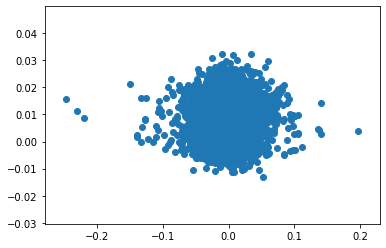

In [44]:
internal_goodness(model_rnn_2inputs, x_test, y_test)

compare true to predicted values of internal validation on learned dataset: 


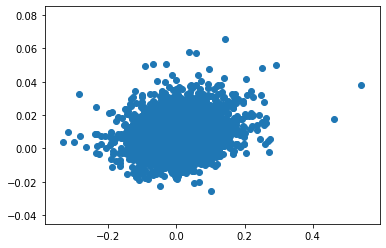

In [45]:
internal_goodness(model_rnn_2inputs, x_train, y_train)

compare true to predicted values of internal validation on learned dataset: 


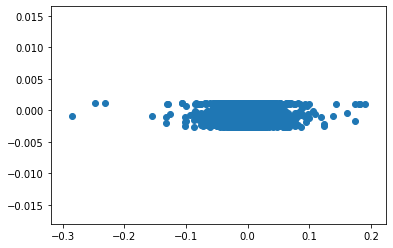

In [23]:
internal_goodness(model_cnn_2inputs,x_test,y_test)

compare true to predicted values of internal validation on learned dataset: 


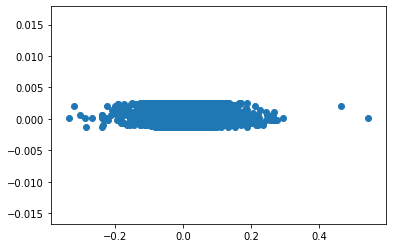

In [46]:
internal_goodness(model_cnn_2inputs,x_train,y_train)

In [47]:
internal_goodness(model_cnn,x_test,y_test)

NameError: name 'model_cnn' is not defined

In [ ]:
internal_goodness(model_cnn,x_train,y_train)

In [ ]:
internal_goodness(model_fully,x_test,y_test)

In [ ]:
internal_goodness(model_fully,x_train,y_train)

In [ ]:
internal_goodness(model_rnn,x_test,y_test)

In [ ]:
internal_goodness(model_rnn,x_train,y_train)

Function to check external goodness - predicted values for future data vs actual future data

In [141]:
def external_goodness(model, x_new, y_new):
    print('compare true to predicted values of external validation set: ')
    y_pred = model.predict(x_new)
    color =  ["r", "b", "g"]
    for i in range(3):
        plt.plot(y_new[:30,i],c=color[i], label = 'true')
        plt.plot(y_pred[:30,i], c=color[i], linestyle='--', label = 'pred')
    plt.legend()

compare true to predicted values of external validation set: 


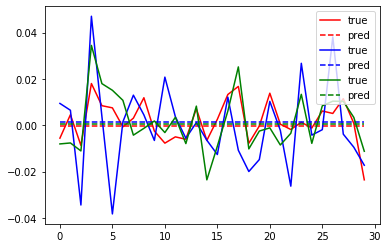

In [142]:
external_goodness(model_cnn_2inputs,x_test,y_test)

compare true to predicted values of external validation set: 


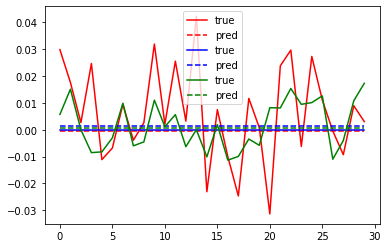

In [143]:
external_goodness(model_cnn_2inputs,x_train,y_train)

In [ ]:
external_goodness(model_cnn,x_test,y_test)

In [ ]:
external_goodness(model_cnn,x_train,y_train)

In [ ]:
external_goodness(model_fully,x_test,y_test)

In [ ]:
external_goodness(model_fully,x_train,y_train)

In [ ]:
external_goodness(model_rnn,x_test,y_test)

In [ ]:
external_goodness(model_rnn,x_train,y_train)

In [ ]:
x_test2 = x_test.copy()

In [ ]:
for i in range(1,20):
    x_test2[:,:,i] = x_test[:,:,0]

In [ ]:
external_goodness(model_cnn, x_test2,y_test)

In [28]:
def largest(array, amount):
    return array.argsort()[:,-amount:]

In [29]:
def compare_top(model, x_test, y_test):
    amount = 5
    mean_all = np.mean(y_test)
    y_pred = model.predict(x_test)
    top_index = largest(y_pred,amount)
    mean_mach = np.mean(y_test[top_index])
    return mean_mach-mean_all

In [ ]:
compare_top(model_cnn, x_test, y_test)

In [ ]:
compare_top(model_fully, x_test, y_test)

In [ ]:
compare_top(model_rnn, x_test, y_test)

In [30]:
compare_top(model_cnn_2inputs, x_test, y_test)

0.005896959728322425